In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import matplotlib.colors as colors
from utils.my_plotting_lib import plot_barcodes, plot_conf_ellipse, label_axes
from utils.fim_utils import computeCriteria, logTransform
from toggle_model import ToggleSwitchModel
rc('text', usetex=True)

In [63]:
model = ToggleSwitchModel()
theta = np.array([model.bx,
                model.by,
                model.kx,
                model.ky,
                model.ayx,
                model.axy,
                model.nyx,
                model.nxy,
                model.gammax,
                model.gammay])
fims = {}
with np.load('results/fim_exact.npz') as _:
    fims['full'] = _["fim"]
with np.load('results/fim_marginals.npz') as _:
    fims['partial_0'] = _['fim0']
    fims['partial_1'] = _['fim1']
for key in fims.keys():
    logTransform(fims[key], theta)

## Compare joint vs. single-species measurements and half-and-half combination of measurement types

In [64]:
def find_multiple_time_fim(dt: int, fims: np.ndarray)->np.ndarray:
    """
    Compute the FIM associated with an experiment that collect cells over 2 equi-spaced time points from the FIMs associated with
    single time points.
    """
    idxs = [k*dt for k in range(1, 3)]
    return np.sum(fims[idxs], axis=0)

In [65]:
fim_mt_single_obs = {}
n_cells = 1000
max_dt = 200
for observation_type in ['full', 'partial_0', 'partial_1']:
    fim_mt_single_obs[observation_type] = []
    for dt in range(0, max_dt+1):
        fim_mt_single_obs[observation_type].append(
            find_multiple_time_fim(dt, n_cells*fims[observation_type])
        )
    fim_mt_single_obs[observation_type] = np.array(fim_mt_single_obs[observation_type])
fim_mt_half = []
for dt in range(1, max_dt+1):
        fim_mt_half.append(find_multiple_time_fim(dt, n_cells//2*fims['partial_0']+n_cells//2*fims['partial_1']))
fim_mt_half = np.array(fim_mt_half)

In [66]:
# D-optimality for single observation

In [67]:
d_full = computeCriteria(fim_mt_single_obs['full'])
d_partial0 = computeCriteria(fim_mt_single_obs['partial_0'])
d_partial1 = computeCriteria(fim_mt_single_obs['partial_1'])
d_mix = computeCriteria(fim_mt_half)

In [68]:
dt_opt_full = np.argmax(d_full)
dt_opt_partial0 = np.argmax(d_partial0)
dt_opt_partial1 = np.argmax(d_partial1)
dt_opt_mix = np.argmax(d_mix)

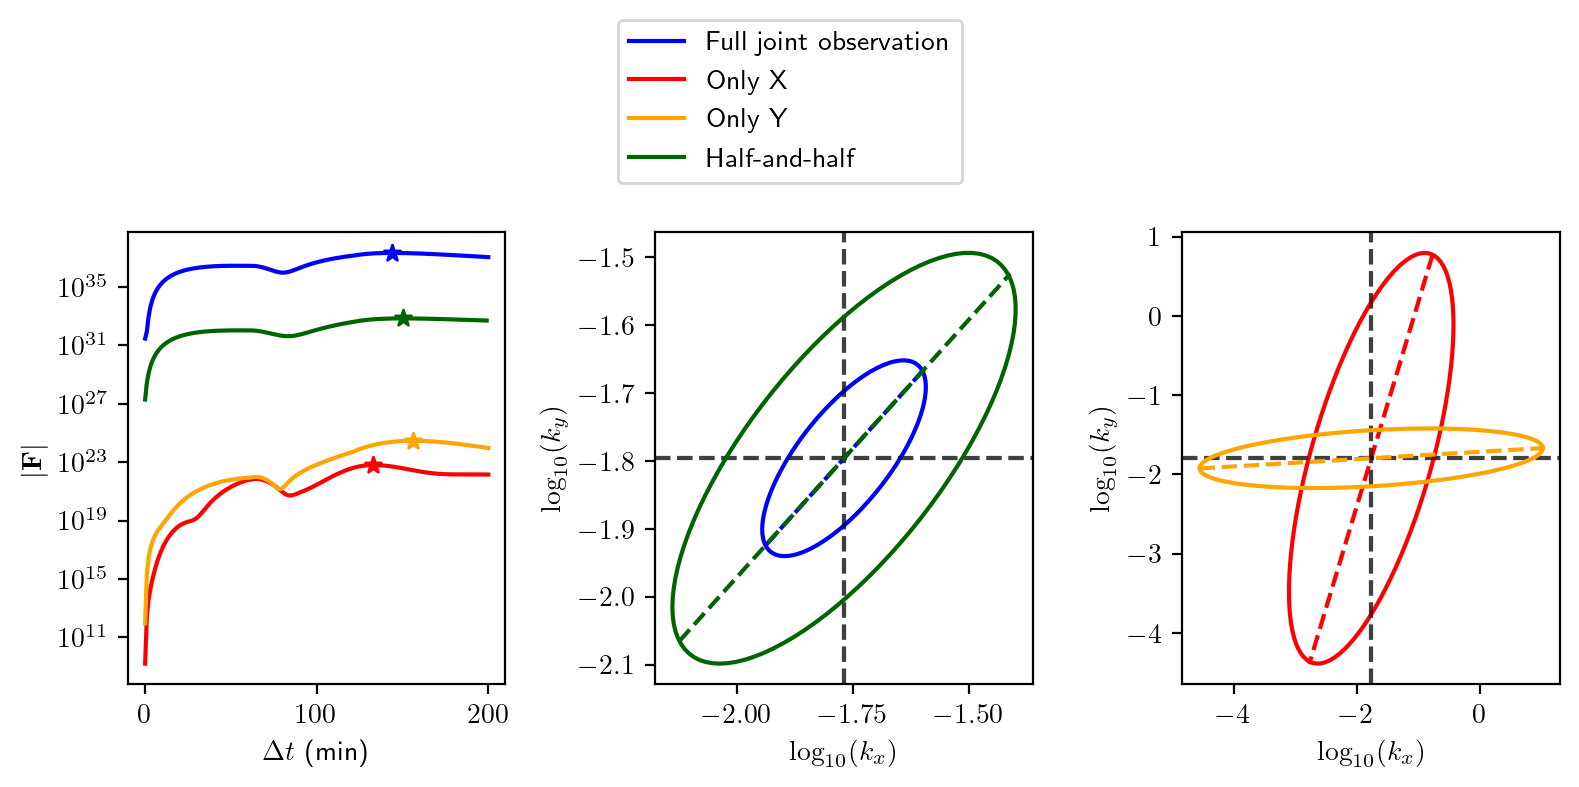

In [69]:
fig = plt.figure(figsize=(8, 3), dpi=200, tight_layout=True)
axs = fig.subplots(1, 3)

axs[0].plot(d_full, color="blue", label="Full joint observation")
axs[0].plot(d_partial0, color="red", label="Only X")
axs[0].plot(d_partial1, color="orange", label="Only Y")
axs[0].plot(d_mix, color="darkgreen", label="Half-and-half")
axs[0].set_yscale("log")
axs[0].set_ylabel(r"$|\mathbf{F}|$")
axs[0].set_xlabel(r"$\Delta{t}$ (min)")
axs[0].scatter(dt_opt_full, d_full[dt_opt_full], color="blue", marker="*")
axs[0].scatter(dt_opt_mix, d_mix[dt_opt_mix], color="darkgreen", marker="*")
axs[0].scatter(dt_opt_partial0, d_partial0[dt_opt_partial0], color="red", marker="*")
axs[0].scatter(dt_opt_partial1, d_partial1[dt_opt_partial1], color="orange", marker="*")

plot_conf_ellipse(fim=fim_mt_single_obs['full'][dt_opt_full], num_sigma=3,
                  ax=axs[1], par_idx=[2, 3], theta=np.log10(theta),
                  color="blue")
plot_conf_ellipse(fim=fim_mt_half[dt_opt_mix], num_sigma=3,
                   ax=axs[1], par_idx=[2, 3], theta=np.log10(theta),
                  color="darkgreen")
axs[1].set_xlabel(r"$\log_{10}(k_x)$")
axs[1].set_ylabel(r"$\log_{10}(k_y)$")

plot_conf_ellipse(fim=fim_mt_single_obs['partial_0'][dt_opt_partial0], num_sigma=3,
                  ax=axs[2], par_idx=[2, 3], theta=np.log10(theta),
                  color="red")
plot_conf_ellipse(fim=fim_mt_single_obs['partial_1'][dt_opt_partial1], num_sigma=3,
                   ax=axs[2], par_idx=[2, 3], theta=np.log10(theta),
                  color="orange")
axs[2].set_xlabel(r"$\log_{10}(k_x)$")
axs[2].set_ylabel(r"$\log_{10}(k_y)$")

h, l = axs[0].get_legend_handles_labels()
fig.legend(h, l, loc="lower center", bbox_to_anchor=(0.5, 1, 0, 0.5))
fig.savefig("figs/toggle_single_vs_half.png", dpi=300, bbox_inches="tight")

## Joint measurement at optimal sampling period vs mixed measurements under optimal sampling period and mixture

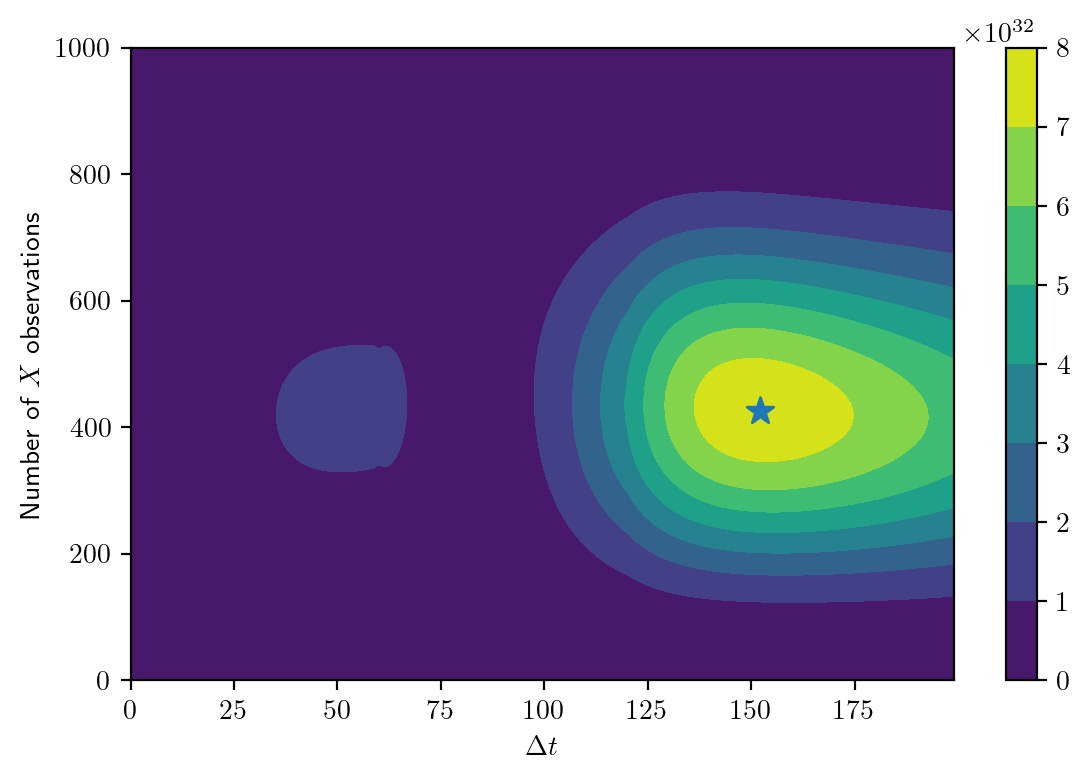

In [70]:
with np.load('results/combined_fim_dopt.npz', allow_pickle=True) as _:
    fim_opt_dt_mixture = _['fim_opt']
    nx_opt = _['nx_opt']
    dt_opt = _['dt_opt']
    fim_mixture_dets = _['fim_dets']

fig = plt.figure(dpi=200, tight_layout=True)
ax = fig.subplots(1,1)
h = ax.contourf(fim_mixture_dets)
fig.colorbar(h)
ax.set_xlabel(r'$\Delta{t}$')
ax.set_ylabel(r'Number of $X$ observations')
ax.scatter(dt_opt, nx_opt, marker='*', s=100)
fig.savefig('figs/toggle_fim_mixture_dopt.png', dpi=400, bbox_inches="tight")

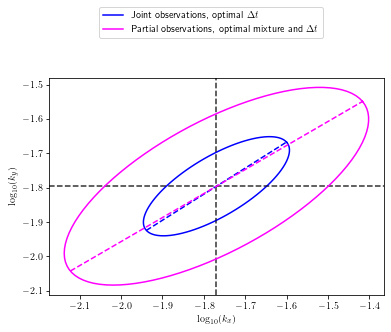

In [71]:
fig, ax = plt.subplots(1,1)
plot_conf_ellipse(fim=fim_mt_single_obs['full'][dt_opt_full], num_sigma=3,
                  ax=ax, par_idx=[2, 3], theta=np.log10(theta),
                  color="blue", label=r"Joint observations, optimal $\Delta{t}$")
plot_conf_ellipse(fim=fim_opt_dt_mixture, num_sigma=3,
                   ax=ax, par_idx=[2, 3], theta=np.log10(theta),
                  color="magenta", label=r"Partial observations, optimal mixture and $\Delta{t}$")
ax.set_xlabel(r"$\log_{10}(k_x)$")
ax.set_ylabel(r"$\log_{10}(k_y)$")
h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc="lower center", bbox_to_anchor=(0.5, 1, 0, 0.5))
fig.savefig("figs/toggle_opt_mixture_kx_ky.png", dpi=300, bbox_inches="tight")

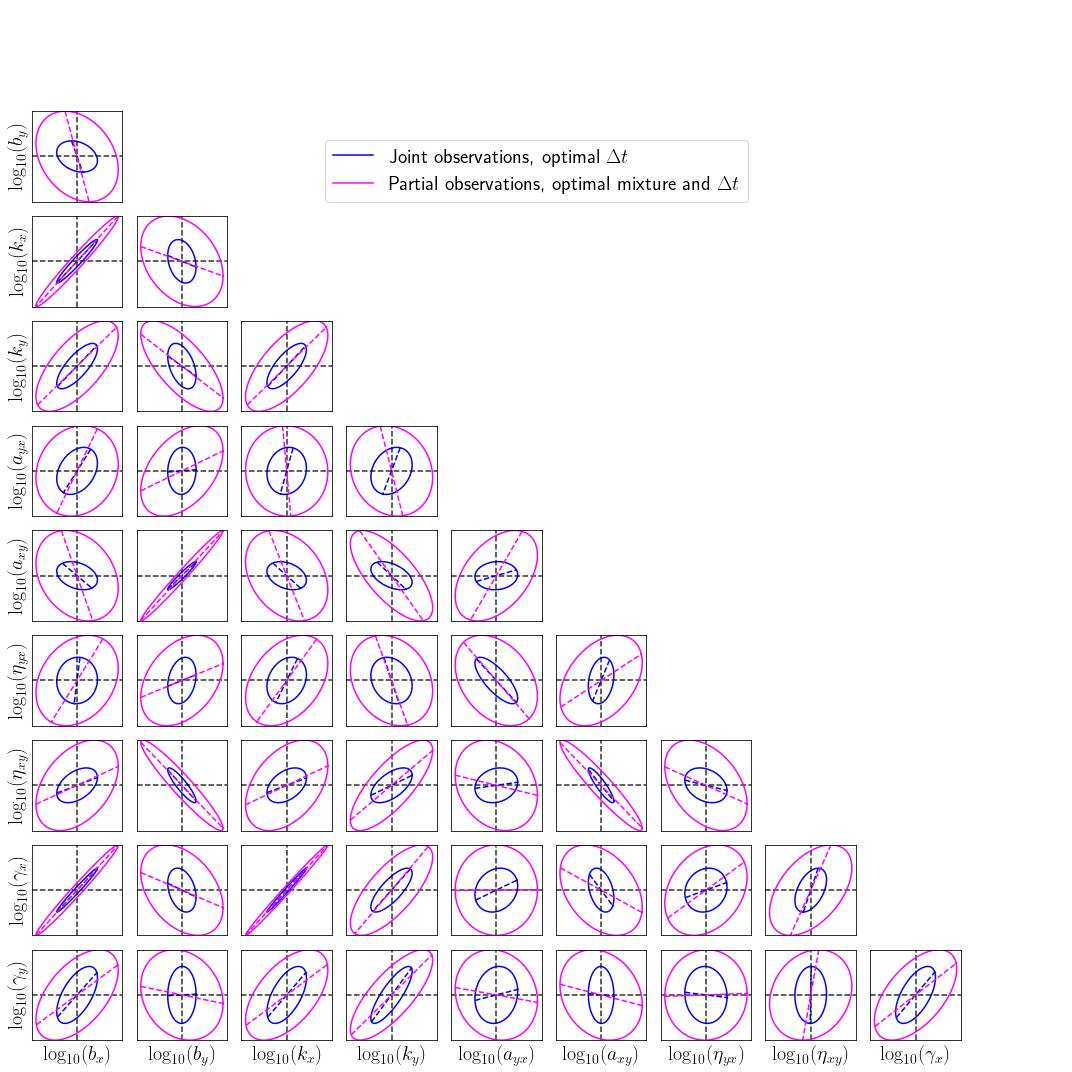

In [72]:
num_pars = model.NUM_PARAMETERS
fig = plt.figure(figsize=(15, 15), tight_layout=True)
axs = fig.subplots(num_pars, num_pars, sharex='col', sharey='row')
for i in range(num_pars):
    for j in range(i, num_pars):
        axs[i, j].axis("off")
    for j in range(0, i):
        plot_conf_ellipse(fim=fim_mt_single_obs['full'][dt_opt_full],
                          num_sigma=3,
                  ax=axs[i, j], par_idx=[j, i], theta=np.log10(theta),
                  color="blue", label=r"Joint observations, optimal $\Delta{t}$")
        plot_conf_ellipse(fim=fim_opt_dt_mixture, num_sigma=3,
                   ax=axs[i, j], par_idx=[j, i], theta=np.log10(theta),
                  color="magenta", label=r"Partial observations, optimal mixture and $\Delta{t}$")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].autoscale(True, tight=True)

parameter_labels=[
    r"$\log_{10}(b_x)$",
    r"$\log_{10}(b_y)$",
    r"$\log_{10}(k_x)$",
    r"$\log_{10}(k_y)$",
    r"$\log_{10}(a_{yx})$",
    r"$\log_{10}(a_{xy})$",
    r"$\log_{10}(\eta_{yx})$",
    r"$\log_{10}(\eta_{xy})$",
    r"$\log_{10}(\gamma_x)$",
    r"$\log_{10}(\gamma_y)$",
]
for i in range(num_pars):
    axs[i, 0].set_ylabel(parameter_labels[i], fontsize=20)
    axs[-1, i].set_xlabel(parameter_labels[i], fontsize=20)

h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc="lower center", bbox_to_anchor=(0.5, 0.8, 0, 0.5), fontsize=20)
fig.savefig("figs/toggle_conf_ellipse_opt_mixture.png", dpi=500, bbox_inches="tight")